<a href="https://colab.research.google.com/github/Oh-Seokjin/MRC_goorm/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean MRC Baseline

## Dependency
다음과 같은 라이브러리를 사용한다.
- [Konlpy](https://konlpy.org/ko/latest/index.html): 파이썬 한국어 NLP 처리기
- [Mecab-korean](https://bitbucket.org/eunjeon/mecab-ko-dic/src): 한국어 형태소 분석기

In [ ]:
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

## 데이터셋 구성
현재 JSON 데이터를 볼 수 있는 클래스를 하나 작성하자.

In [2]:
# QnA에는 ELECTRA 많이 쓰는듯

# Question기준으로 index나누어주는 것이 편리함
# 0, 0, 0 question-context-paragraph 등으로 찾을 수 있도록

# 사용하는 pretrained model 탐색

# AI Hub 데이터를 테스트 데이터로 사용
# 제출 시 짧을수록 유리(문단으로 낼 바에 Blank로 내는 것이 점수 높음)

from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    # indices를 eval_ratio 기준으로 나누어줌
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']

        return {
            # 나중엔 guid를 통해 들고오니까
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)


`load` 메소드를 이용해서 Json 데이터를 불러올 수 있다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = KoMRC.load('/content/drive/MyDrive/Goorm/project02/data/train.json')
print("Number of Samples:", len(dataset))
print(dataset[10])

Number of Samples: 12037
{'guid': 'f7c95fd5471a4e3eb8f25ffb2741f60f', 'context': '“제트기가 음속을 돌파하려면 비행기의 모든 소재가 다 바뀌어야 한다. 재료공학부터 기초물리, 화학까지 첨단기술이 총동원돼야 한다. 설계도는 물론이고 엔진과 부품을 완전히 바꿔야 한다.”6일 경기도 용인 삼성인력개발원에 모인 200여 삼성그룹 임원들은 이건희 회장이 7년 전 강조한 ‘마하경영’의 의미를 되새겼다. 김동재 연세대 국제학대학원 교수의 마하경영 강연에 이어 분임조별 토론이 벌어졌다. 이틀 동안 진행된 교육에서 강연과 토론에 할애된 시간만 20시간이 넘었다. 삼성이 매년 2월 진행하는 임원진 교육 현장이다. 삼성은 그룹 내 2000여명의 임원을 10개 조로 나눠 2월 한 달 동안 1박2일간 합숙 교육한다.올해는 한계돌파를 위한 마하경영에 임원 교육의 초점이 맞춰졌다. 지난 연말 열린 사장단 세미나와 지난달 신임 임원 교육에 이어 2월 기존 임원진 교육에서도 공통된 주제는 마하경영이다. 하나의 방향을 정하면 그대로 실행에 옮기는 삼성의 스파르타식 교육의 한 단면이다.이날 강연을 들은 한 임원은 “그룹 차원에서 설정한 방향과 가치를 공유하며 정신을 무장하는 자리”라며 “현업에서 이를 어떻게 실천할 것인지 고민해보는 시간을 가졌다”고 말했다. 그는 “삼성의 힘은 결국 이런 교육에서 나온다”고 덧붙였다. 이날 마하경영을 설명한 김 교수는 지난달 신임 임원 교육에서도 강연자로 나섰다. ‘마하(Mach)’는 음속 제트기의 속도를 측정하는 단위다. 그는 “음속을 돌파하려면 부분 개보수가 아니라 자기부정부터 시작해 행동부터 생각까지 근본적으로 바뀌어야 한다”고 강조했다.이 회장은 2006년 당시 전자 계열사 사장들에게 “삼성의 약점을 보완하고 성장하려면 마하1이나 2가 아니라 마하3은 돼야 한다”며 “현재 삼성은 음속 이하의 수준인 만큼 진정한 글로벌 선진 기업이 되려면 더 분발해야 한다”고 했다.1993년 신경영 선언 당

`split` 메소드를 이용하면 데이터 셋을 나눌 수 있다.

In [5]:
# train:eval = 9:1
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘2

단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.

In [6]:
import konlpy

# 한국어 형태소 분석기
mecab = konlpy.tag.Mecab()

sentence = mecab.morphs("단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.")
poses = mecab.pos("단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.")
nouns = mecab.nouns("단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.")

# tokenizing 자체는 잘 되지만, 공백이 모두 날아감 -> 복구가 어려움
# 슬라이싱 시 공백이 있는 것이 더 토큰 구별 수월함 
print(sentence)
print(poses)
print(nouns)


['단어', '단위', '로', '토큰', '화', '해서', '정답', '위치', '를', '찾', '기', '위하', '여', '토큰', '화', '및', '위치', '인덱싱', '을', '하', '는', '클래스', '를', '상속', '을', '통해', '작성', '해', '보', '자', '.']
[('단어', 'NNG'), ('단위', 'NNG'), ('로', 'JKB'), ('토큰', 'NNG'), ('화', 'XSN'), ('해서', 'XSV+EC'), ('정답', 'NNG'), ('위치', 'NNG'), ('를', 'JKO'), ('찾', 'VV'), ('기', 'ETN'), ('위하', 'VV'), ('여', 'EC'), ('토큰', 'NNG'), ('화', 'XSN'), ('및', 'MAJ'), ('위치', 'NNG'), ('인덱싱', 'NNG'), ('을', 'JKO'), ('하', 'VV'), ('는', 'ETM'), ('클래스', 'NNP'), ('를', 'JKO'), ('상속', 'NNG'), ('을', 'JKO'), ('통해', 'VV+EC'), ('작성', 'NNG'), ('해', 'XSV+EC'), ('보', 'VX'), ('자', 'EF'), ('.', 'SF')]
['단어', '단위', '토큰', '정답', '위치', '토큰', '위치', '인덱싱', '클래스', '상속', '작성']


In [7]:
from typing import Generator

import konlpy

class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tagger = konlpy.tag.Mecab()

    # (형태소, (시작index, 끝index))를 tokens에 저장

    # char기반으로 세는 것과 morphs 기반으로 세는 것이 다름 > 둘 사이를 맞춰야야
    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        for morph in self._tagger.morphs(sentence):
            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
        return tokens
            
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)
        question = self._tagger.morphs(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No Matched end position")

                answers.append({
                    'start': start,
                    'end': end
                })
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }
        

In [8]:
dataset = TokenizedKoMRC.load('/content/drive/MyDrive/Goorm/project02/data/train.json')

train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인

In [9]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['서강대', '메리', '홀', '대극장']


## Vocab 생성 및 Indexing
토큰화된 데이터 셋을 기준으로 Vocab을 만들고 인덱싱을 하는 `Indexer`를 만들자.

In [10]:
from typing import Sequence
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm

class Indexer:
    def __init__(self,
        id2token: List[str], 
        max_length: int=1024,
        pad: str='<pad>', unk: str='<unk>', cls: str='<cls>', sep: str='<sep>'
    ):
        self.pad = pad
        self.unk = unk
        self.cls = cls
        self.sep = sep
        self.special_tokens = [pad, unk, cls, sep]

        self.max_length = max_length

        self.id2token = self.special_tokens + id2token
        self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}

    @property
    def vocab_size(self):
        return len(self.id2token)
    
    @property
    def pad_id(self):
        return self.token2id[self.pad]
    @property
    def unk_id(self):
        return self.token2id[self.unk]
    @property
    def cls_id(self):
        return self.token2id[self.cls]
    @property
    def sep_id(self):
        return self.token2id[self.sep]

    @classmethod
    def build_vocab(cls,
        dataset: TokenizedKoMRC, 
        min_freq: int=5 # 빈도 5 미만은 삭제
    ):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))

        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self,
        token_ids: Sequence[int]
    ):
        return [self.id2token[token_id] for token_id in token_ids]

    def sample2ids(self,
        sample: Dict[str, Any],
    ) -> Dict[str, Any]:
        context = [self.token2id.get(token, self.unk_id) for token in sample['context']]
        question = [self.token2id.get(token, self.unk_id) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        # 구별용 토큰
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)
    
        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(answer['start'] + len(question) + 2, self.max_length - 1)
            end = min(answer['end'] + len(question) + 2, self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [11]:
indexer = Indexer.build_vocab(dataset)
print(indexer.sample2ids(dev_dataset[0]))

Counting Vocab:   0%|          | 0/12037 [00:00<?, ?it/s]

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

쉽게 Indexer를 활용하기 위해 Indexer가 포함된 데이터 셋을 만들자.

In [12]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample


In [13]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])

[2, 1, 1100, 7, 2226, 71, 4336, 30, 25656, 1139, 97, 57, 39, 2874, 39, 2684, 974, 170, 3, 67, 2912, 4336, 830, 97, 1250, 1278, 553, 1607, 2344, 41, 2239, 30, 4, 3276, 32, 6946, 25656, 4344, 82, 2339, 1386, 15, 1016, 4336, 257, 4355, 695, 4344, 4335, 830, 66, 2412, 4336, 830, 2239, 695, 2386, 695, 4355, 830, 17, 97, 834, 71, 183, 36128, 12542, 588, 8, 64, 90, 9, 276, 142, 1, 4335, 4333, 29910, 66, 132, 9, 64, 246, 130, 530, 9, 24315, 19208, 1, 29106, 4333, 175, 66, 4336, 257, 11, 257, 74, 6503, 1, 97, 649, 20, 183, 2830, 7, 635, 30, 14, 588, 85, 9, 64, 246, 130, 1375, 9, 276, 142, 1, 19205, 175, 66, 4336, 257, 2239, 695, 2226, 830, 74, 33837, 4336, 830, 834, 28079, 183, 1, 588, 246, 130, 1513, 64, 85, 9, 6741, 1807, 1011, 29910, 175, 30, 14, 15, 9493, 1293, 2500, 20, 5450, 135, 74, 981, 20, 2426, 17, 43, 1139, 97, 11653, 4336, 2839, 7081, 9478, 2462, 2239, 332, 97, 4133, 20, 17011, 97, 12211, 407, 402, 38, 39, 950, 14, 15, 183, 36128, 12542, 191, 39, 2386, 97, 2286, 243, 2226, 71, 1, 41

## Transformer Encoder를 활용한 MRC 모델
![Bert for MRC](https://miro.medium.com/max/340/1*cXDOP0gsE7Zp8-sgZqYfTA.png)

Transformer 인코더 마지막에 Linear Layer를 붙여 정답의 시작과 끝을 맞추는 간단한 모델을 생성보자.

In [ ]:
'''
C: 지난해 주요 연극상을 나누어 가졌다
Q: 정답은? 4번째 char부터

tokenizing -> 전처리 data
index 단위에서 token 단위로 바꿈

index         0    1    2  3      4     5    6   7  8   9      10      11
inputids = [CLS] 정답 은 [SEP] 지난해 주요 연극 상 을 나누어 가졌다 [SEP]
tokentypeids  0    0    0   1    1      1     1   1 1    1     1        1 
attentionmask는 모두 1

Answer -> start:end = 5:7
0:3은 question부분이므로 나오지 않기를 바랄 것
'''

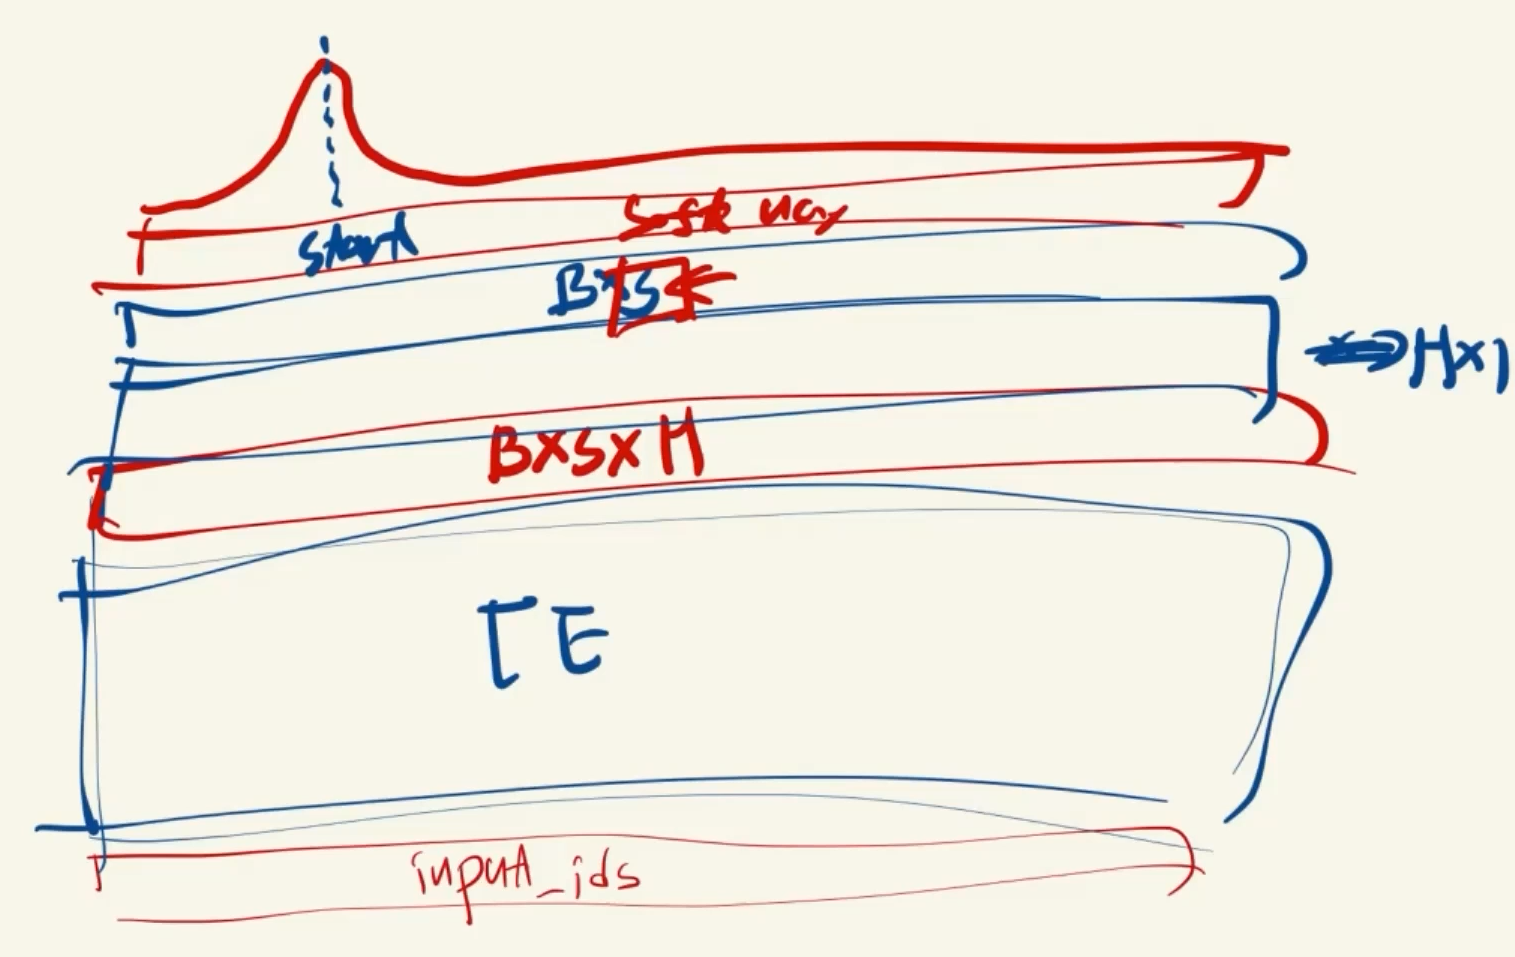

In [ ]:
# Overall Process

'''
1.  transformer encoder에 input ids를 태움
    이때 input ids dim = s, size = Batch size * s * embedding size(H)
    B = #sample

2.  ouput size 또한 위의 size와 같다. 

3.  결국 숫자를 뱉어내야 하는가?
    아니면 input_ids_dim인 s 내에서 start index 와 end index를 찾아야 하는가?
    
4.  h의 차원을 낮춰줘야 함 ->  linear layer(H*1) 
    -> size = B * s * 1
    -> squeeze = B * s
    s를 각각의 logit, 혹은 intensity로 생각할 수 있음
    
5.  이후 softmax를 걸어서 probability를 구할 수 있음

6.  start, end 모두 예측해야 하므로 B * s를 하나 더 만들어줌
    각각 확률이 높아지도록 모델링   
    총 2가지의 projection 必

# question부분은 포함하지 않고 softmax걸어주는 테크닉
# start end 순서 거꾸로 나올 수도 있으므로 보정해주는 아이디어 필요
'''

In [ ]:
import torch.nn as nn

from transformers.models.bert.modeling_bert import (
    BertModel,
    BertPreTrainedModel
)

## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BertForQuestionAnswering(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=False)
        self.start_linear = nn.Linear(config.hidden_size, 1)
        self.end_linear = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

## 학습 준비

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )

        return samples

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자

collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [ ]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(batch['input_ids'])
print(list(batch.keys()))

In [ ]:
import torch
from transformers import BertConfig

torch.manual_seed(42)
config = BertConfig(
     vocab_size=indexer.vocab_size,
     max_position_embeddings=1024,
     hidden_size=256,
     num_hidden_layers=4,
     num_attention_heads=4,
     intermediate_size=1024
)
model = BertForQuestionAnswering(config)
# model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [ ]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

os.makedirs('dump', exist_ok=True)
train_losses = []
dev_losses = []

step = 0

for epoch in range(1, 31):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    progress_bar = tqdm(train_loader, desc='Train')
    for batch in progress_bar:
        del batch['guid'], batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')
        
        start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)
        (loss / accumulation).backward()
        running_loss += loss.item()
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        if step % accumulation:
            continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        losses.append(running_loss / accumulation)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")
    train_losses.append(mean(losses))
    print(f"train score: {train_losses[-1]:.3f}")

    # Evaluation
    losses = []
    for batch in tqdm(dev_loader, desc="Evaluation"):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        losses.append(loss.item())
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")

    model.save_pretrained(f'dump/model.{epoch}')

In [ ]:
import matplotlib.pyplot as plt

t = list(range(1, 31))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

![loss_plot](https://github.com/mynsng/mynsng.github.io/blob/master/assets/images/__results___26_0.png?raw=true)

학습 데이터 셋에 Overfitting이 일어나는 것을 확인할 수 있다.

## Answer Inference
모델의 Output을 활용해서 질문의 답을 찾는 코드를 작성하자.

In [ ]:
model = BertForQuestionAnswering.from_pretrained('dump/model.30')
model.cuda()
model.eval()

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start = sample['position'][start][0]
    end = sample['position'][end][1]

    print('Answer:', sample['context'][start:end])

## Test 출력 파일 작성

In [ ]:
test_dataset = TokenizedKoMRC.load('/content/drive/MyDrive/Goorm/project02/data/test.json')

test_dataset = IndexerWrappedDataset(test_dataset, indexer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

In [ ]:
import csv

os.makedirs('out', exist_ok=True)
with torch.no_grad(), open('out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(test_dataset, "Testing"):
        input_ids, token_type_ids = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids")
        ]
    
        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
    
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()
    
        start = index // len(end_prob)
        end = index % len(end_prob)
    
        start = sample['position'][start][0]
        end = sample['position'][end][1]

        rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)